In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score
import datetime as dt

In [2]:

# Load the dataset
# Make sure to upload 'data.csv' to your Colab environment
try:
    df = pd.read_csv('data_customer.csv', encoding='latin1')
    print("Dataset loaded successfully.")
except FileNotFoundError:
    print("Error: 'data.csv' not found. Please upload the file to your Colab environment.")
    exit()

Dataset loaded successfully.


In [3]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [4]:
# --- 1. Data Cleaning and Preprocessing ---
print("\n--- Starting Data Cleaning and Preprocessing ---")

# Drop rows with missing CustomerID
df.dropna(axis=0, subset=['CustomerID'], inplace=True)

# Remove returns (negative quantity)
df = df[df['Quantity'] > 0]

# Remove items with zero unit price
df = df[df['UnitPrice'] > 0]

# Convert CustomerID to integer
df['CustomerID'] = df['CustomerID'].astype(int)

# Convert InvoiceDate to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], format='%m/%d/%Y %H:%M', errors='coerce')

# Calculate TotalPrice
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']
print("Data cleaning and preprocessing complete.")


--- Starting Data Cleaning and Preprocessing ---
Data cleaning and preprocessing complete.


In [5]:
df['Country'].unique()

array(['United Kingdom', 'France', 'Australia', 'Netherlands', 'Germany',
       'Norway', 'EIRE', 'Switzerland', 'Spain', 'Poland', 'Portugal',
       'Italy', 'Belgium', 'Lithuania', 'Japan', 'Iceland',
       'Channel Islands', 'Denmark', 'Cyprus', 'Sweden', 'Finland',
       'Austria', 'Greece', 'Singapore', 'Lebanon',
       'United Arab Emirates', 'Israel', 'Saudi Arabia', 'Czech Republic',
       'Canada', 'Unspecified', 'Brazil', 'USA', 'European Community',
       'Bahrain', 'Malta', 'RSA'], dtype=object)

In [6]:
df[df['Country']=='United Kingdom']['CustomerID'].value_counts()

,count
CustomerID,
17841,7847
14096,5111
12748,4595
14606,2700
15311,2379
...,...
16148,1
16073,1
16738,1


In [7]:



# Grouping per customer
snapshot_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

# Feature Engineering
features = df.groupby('CustomerID').agg(
    Var1=('InvoiceDate', lambda x: (snapshot_date - x.max()).days),  # Days since last purchase
    Var2=('InvoiceNo', lambda x: x.nunique()),                       # Total transactions
    Var3=('Quantity', 'sum'),                                        # Total products
    Var4=('TotalPrice', 'sum'),                                      # Total expenditure
    Var5=('TotalPrice', lambda x: x.sum() / x.count()),              # Avg transaction cost
    Var6=('Description', lambda x: x.nunique()),                     # Product types
    Var7=('InvoiceDate', lambda x: np.mean((x.sort_values() - x.min()).dt.days)),  # Avg days to purchase
    Var8=('InvoiceDate', lambda x: np.median((x.sort_values() - x.min()).dt.days)),# Expected purchase days
    Var9=('Country', lambda x: int((x == 'United Kingdom').all())),  # From UK
    Var10=('InvoiceNo', lambda x: sum(x.astype(str).str.startswith('C'))), # Cancel freq
)

# Var11: Average monthly expenditure
df['YearMonth'] = df['InvoiceDate'].dt.to_period('M')
monthly_exp = df.groupby(['CustomerID', 'YearMonth'])['TotalPrice'].sum().reset_index()
monthly_avg = monthly_exp.groupby('CustomerID')['TotalPrice'].mean()
features['Var11'] = monthly_avg

# Reset index for usability
features = features.reset_index()

# Final Output
print(features.head())





   CustomerID  Var1  Var2   Var3      Var4          Var5  Var6        Var7  \
0       12346   326     1  74215  77183.60  77183.600000     1    0.000000   
1       12347     2     7   2458   4310.00     23.681319   103  176.884615   
2       12348    75     4   2341   1797.24     57.975484    22   52.419355   
3       12349    19     1    631   1757.55     24.076027    73    0.000000   
4       12350   310     1    197    334.40     19.670588    17    0.000000   

    Var8  Var9  Var10         Var11  
0    0.0     1      0  77183.600000  
1  183.0     0      0    615.714286  
2    0.0     0      0    449.310000  
3    0.0     0      0   1757.550000  
4    0.0     0      0    334.400000  


In [8]:
features['Var9'].value_counts()

,count
Var9,
1,3920
0,418


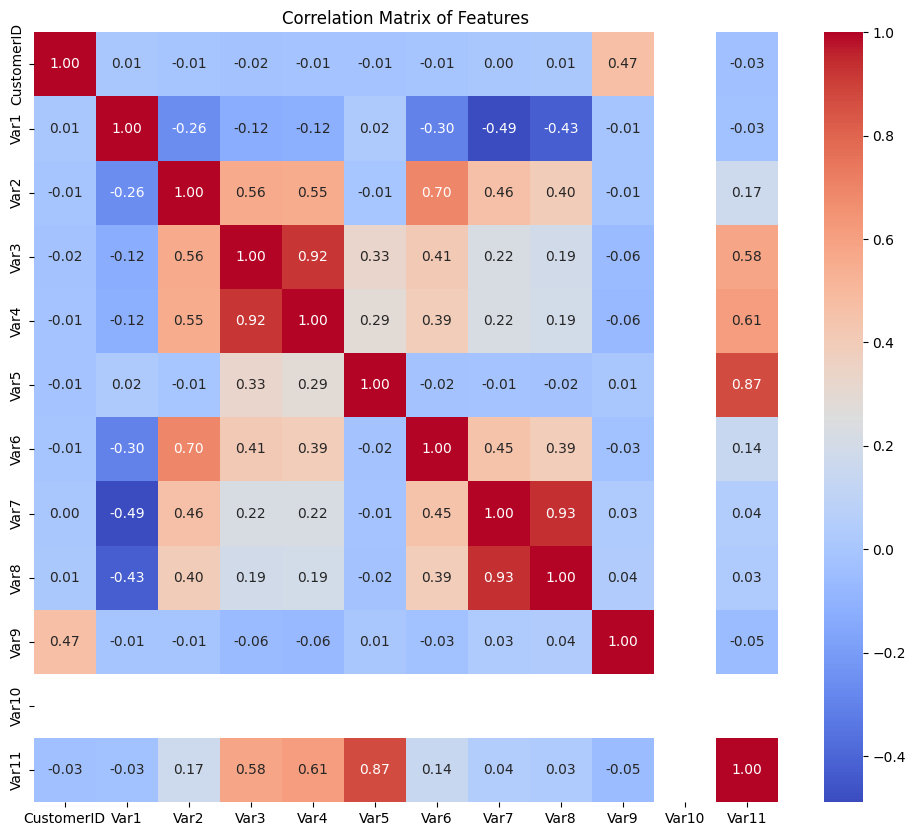

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
sns.heatmap(features.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Features')
plt.show()

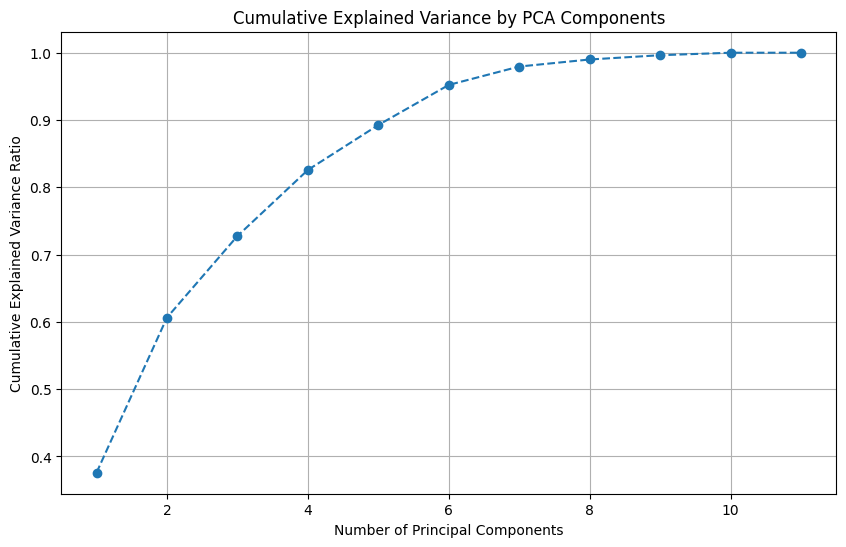

Explained Variance Ratio per Principal Component:
[0.37574146 0.23061824 0.1211756  0.09820238 0.06681053 0.05958473
 0.02733546 0.01047952 0.00634195 0.00371014 0.        ]

Cumulative Explained Variance Ratio:


array([0.37574146, 0.6063597 , 0.72753529, 0.82573768, 0.89254821,
       0.95213294, 0.9794684 , 0.98994792, 0.99628986, 1.        ,
       1.        ])

In [10]:
# prompt: Perform PCA on features dataset and also plot cumulative variance contribution of PCA

from sklearn.decomposition import PCA

# Scale the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features.drop('CustomerID', axis=1))

# Perform PCA
pca = PCA()
principal_components = pca.fit_transform(features_scaled)

# Calculate cumulative explained variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Plot cumulative explained variance
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.title('Cumulative Explained Variance by PCA Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.grid(True)
plt.show()

# Print explained variance ratio
print("Explained Variance Ratio per Principal Component:")
print(pca.explained_variance_ratio_)
print("\nCumulative Explained Variance Ratio:")
cumulative_variance

In [11]:
# Redo PCA with 6 components
pca = PCA(n_components=6)
principal_components_6 = pca.fit_transform(features_scaled)

# Create a DataFrame of the components
pc_df = pd.DataFrame(principal_components_6, columns=[f'PC{i+1}' for i in range(6)])
pc_df['CustomerID'] = features['CustomerID'].values


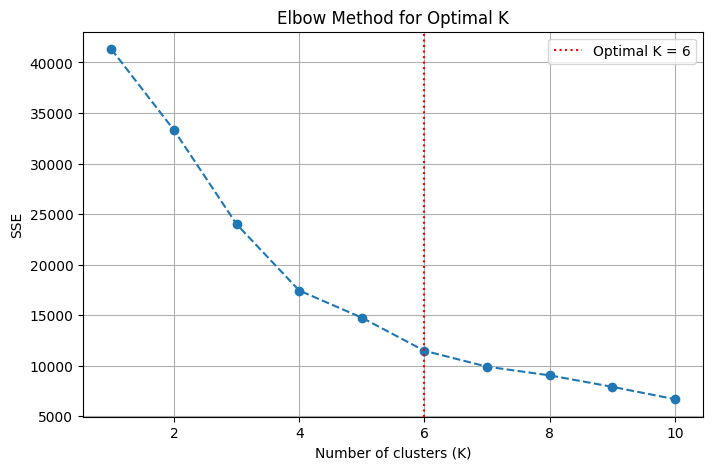

In [12]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Elbow method on PCA-reduced data
sse = []
K_range = range(1, 11)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(principal_components_6)
    sse.append(kmeans.inertia_)

plt.figure(figsize=(8,5))
plt.plot(K_range, sse, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of clusters (K)')
plt.ylabel('SSE')
plt.grid(True)
plt.axvline(x=6, color='red', linestyle=':', label='Optimal K = 6')
plt.legend()
plt.show()


In [13]:
kmeans_qlde = KMeans(n_clusters=6, random_state=42)
clusters_qlde = kmeans_qlde.fit_predict(principal_components_6)

# Append cluster to DataFrame
pc_df['Cluster_QLDE'] = clusters_qlde


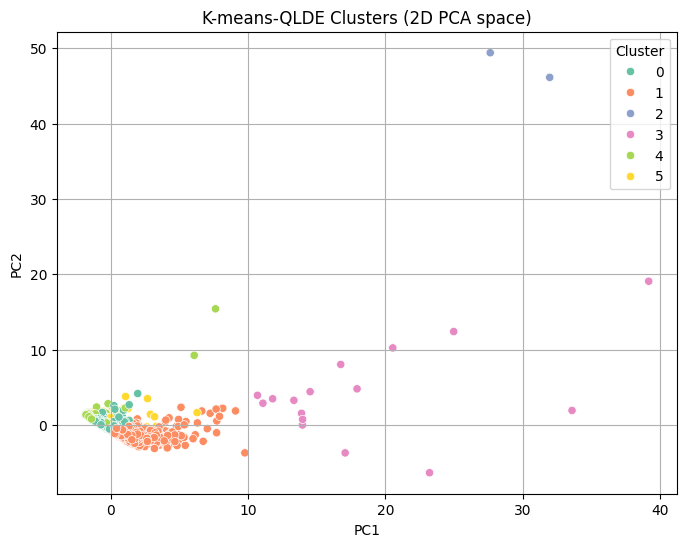

In [14]:
import seaborn as sns

plt.figure(figsize=(8,6))
sns.scatterplot(x=pc_df['PC1'], y=pc_df['PC2'], hue=pc_df['Cluster_QLDE'], palette='Set2')
plt.title('K-means-QLDE Clusters (2D PCA space)')
plt.grid(True)
plt.legend(title='Cluster')
plt.show()


In [15]:
cluster_dist = pc_df['Cluster_QLDE'].value_counts(normalize=True) * 100
print("Customer distribution across clusters (QLDE):\n", cluster_dist.round(2))


Customer distribution across clusters (QLDE):
 Cluster_QLDE
0    40.18
1    29.07
4    20.93
5     9.41
3     0.37
2     0.05
Name: proportion, dtype: float64


In [16]:
# Classical K-means (on original scaled 11 features)
kmeans_classical = KMeans(n_clusters=6, random_state=42)
clusters_classical = kmeans_classical.fit_predict(features_scaled)

features['Cluster_Classic'] = clusters_classical
pc_df['Cluster_Classic'] = clusters_classical


In [17]:
from sklearn.metrics import silhouette_score

sil_qlde = silhouette_score(principal_components_6, clusters_qlde)
sil_classic = silhouette_score(features_scaled, clusters_classical)

print(f"Silhouette Score (K-means elbow on PCA): {sil_qlde:.3f}")
print(f"Silhouette Score (Classical K-means): {sil_classic:.3f}")


Silhouette Score (K-means elbow on PCA): 0.424
Silhouette Score (Classical K-means): 0.391


In [18]:
principal_components_6

array([[ 2.76327655e+01,  4.94039495e+01,  3.10195202e+01,
        -3.23697852e+00,  1.92976204e+00,  1.39119549e+01],
       [ 1.68571444e+00, -1.11502331e+00, -5.32587446e-02,
        -3.19511032e+00,  2.80965613e-01, -1.18038236e-01],
       [-3.20566111e-01,  6.21056957e-01, -9.81957615e-01,
        -2.90172946e+00, -2.93801880e-01, -1.60436717e-01],
       ...,
       [-7.10989379e-01,  3.36614780e-02,  2.65511139e-01,
         1.84875059e-01, -1.07679836e+00, -3.12161246e-01],
       [ 2.66291144e+00, -2.17427123e+00,  1.27673828e-02,
         3.12682349e-01,  9.53276004e-02,  1.44578452e+00],
       [ 4.27187082e-01, -4.37742514e-01,  6.52267843e-01,
         1.21217586e-01, -7.74484262e-02, -2.82856714e-01]])

In [23]:

from sklearn.cluster import DBSCAN, AgglomerativeClustering

# DBSCAN Clustering
dbscan = DBSCAN(eps=np.float64(0.3), min_samples=4) # You may need to tune eps and min_samples
clusters_dbscan = dbscan.fit_predict(principal_components_6)

# Agglomerative Clustering
agg_clustering = AgglomerativeClustering(n_clusters=6) # Using 6 clusters based on K-means result
clusters_agg = agg_clustering.fit_predict(principal_components_6)

# Calculate Silhouette Scores
silhouette_dbscan = silhouette_score(principal_components_6, clusters_dbscan) if len(np.unique(clusters_dbscan)) > 1 else -1
silhouette_agg = silhouette_score(principal_components_6, clusters_agg)

print(f"Silhouette Score (DBSCAN on PCA): {silhouette_dbscan:.3f}")
print(f"Silhouette Score (Agglomerative Clustering on PCA): {silhouette_agg:.3f}")

Silhouette Score (DBSCAN on PCA): -0.226
Silhouette Score (Agglomerative Clustering on PCA): 0.405


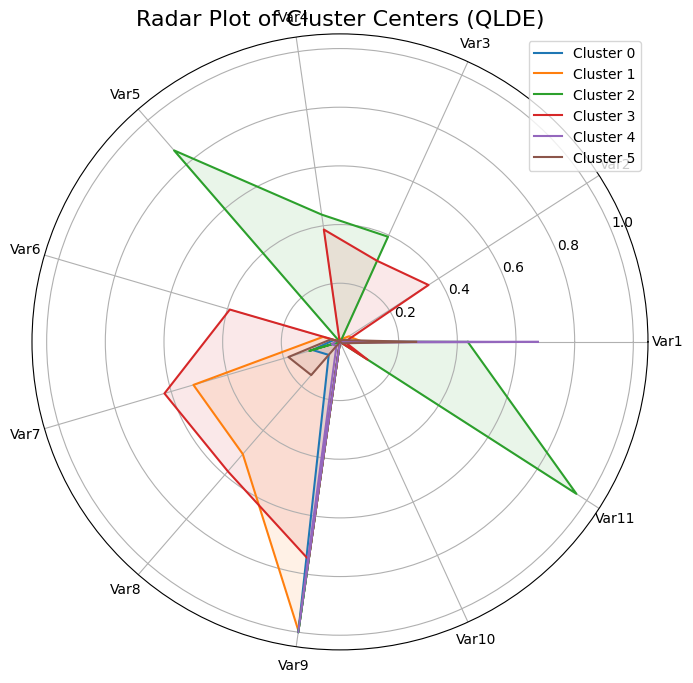

In [20]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Normalize feature space (0-1 scale)
scaler = MinMaxScaler()
features_norm = pd.DataFrame(scaler.fit_transform(features.drop(['CustomerID', 'Cluster_Classic'], axis=1)),
                             columns=[f'Var{i+1}' for i in range(11)])
features_norm['Cluster_QLDE'] = pc_df['Cluster_QLDE']

# Radar Plot of cluster centers
cluster_means = features_norm.groupby('Cluster_QLDE').mean()

labels = cluster_means.columns
num_vars = len(labels)

angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]  # Complete the loop

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

for idx, row in cluster_means.iterrows():
    values = row.tolist()
    values += values[:1]
    ax.plot(angles, values, label=f'Cluster {idx}')
    ax.fill(angles, values, alpha=0.1)

ax.set_title('Radar Plot of Cluster Centers (QLDE)', size=16)
ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels, fontsize=10)
plt.legend(loc='upper right')
plt.show()
